## Import Library

In [ ]:
# import libraries
import os
import time
import math
import re
import string

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.utils import resample

from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [ ]:
# path
path = '/content/dataset_sms_spam_v2.csv'

# read dataset
df = pd.read_csv(path)
df.head()

,Teks,label
0,[PROMO] Beli paket Flash mulai 1GB di MY TELKO...,promo
1,2.5 GB/30 hari hanya Rp 35 Ribu Spesial buat A...,promo
2,"2016-07-08 11:47:11.Plg Yth, sisa kuota Flash ...",promo
3,"2016-08-07 11:29:47.Plg Yth, sisa kuota Flash ...",promo
4,4.5GB/30 hari hanya Rp 55 Ribu Spesial buat an...,promo


In [ ]:
# shape dataset
print('Jumlah data:', len(df))

Jumlah data: 1143


In [ ]:
# info dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Teks    1143 non-null   object
 1   label   1143 non-null   object
dtypes: object(2)
memory usage: 18.0+ KB


In [ ]:
# descriptive statistics
df.describe()

,Teks,label
count,1143,1143
unique,1142,3
top,"bebas nama1, terus nanti kalau ada tgl libur, ...",normal
freq,2,569


## Data Preprocessing

In [ ]:
# function for preprocessing
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)


def cleaning_text(text):
  text = text.translate(str.maketrans("","",string.punctuation))
  text = text.strip()
  text = re.sub('\s+',' ',text)
  text = re.sub(r"\b[a-zA-Z]\b", "", text)
  return text

def remove_tweet_special(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

# Combine preprocessing steps
def preprocess_text(text):
    text = remove_tweet_special(text)
    text = clean_text(text)
    text = cleaning_text(text)
    return text

df['Teks'] = df['Teks'].apply(preprocess_text)
display(df.head())

,Teks,label
0,promo beli paket flash mulai gb di my telkomse...,promo
1,gb hari hanya rp ribu spesial buat anda yang t...,promo
2,plg yth sisa kuota flash anda kb download myte...,promo
3,plg yth sisa kuota flash anda kb download myte...,promo
4,gb hari hanya rp ribu spesial buat anda yang t...,promo


In [ ]:
# check null value
df.isnull().sum()

,0
Teks,0
label,0


In [ ]:
# check duplicated value
df.duplicated().sum()

np.int64(4)

## EDA

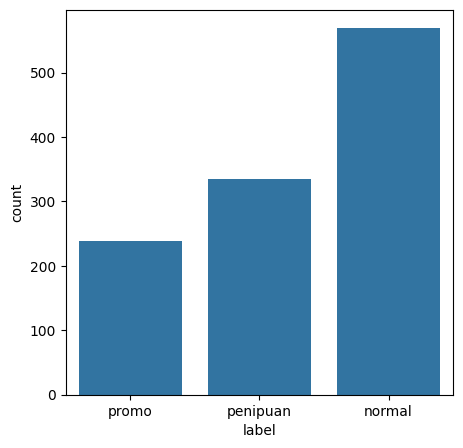

In [ ]:
# check count and unique and top values and their frequency
plt.figure(figsize=(5, 5))
sns.countplot(x=df['label'])
plt.show()

## Feature Engineering

In [ ]:
# remove promo label from dataset
df = df[df['label'] != 'promo']
df.shape

(904, 2)

In [ ]:
df.head()

,Teks,label
239,jika anda bermasalah dgn cc kt stres dgn bunga...,penipuan
240,lelah byr min payment kami solusinya bantu sec...,penipuan
241,dana tunai kta bunga hingga jt syarat ktp cc b...,penipuan
242,roxi cell hanya dengan rp rb anda bisa jadi ag...,penipuan
243,ramadhan selamat anda pemenang rp jt pin code ...,penipuan


In [ ]:
df['label'] = df['label'].apply(lambda x:0 if x=="normal" else 1)
df.head()

,Teks,label
239,jika anda bermasalah dgn cc kt stres dgn bunga...,1
240,lelah byr min payment kami solusinya bantu sec...,1
241,dana tunai kta bunga hingga jt syarat ktp cc b...,1
242,roxi cell hanya dengan rp rb anda bisa jadi ag...,1
243,ramadhan selamat anda pemenang rp jt pin code ...,1


In [ ]:
# create new feature
eda = df.copy()
eda['char_len'] = eda['Teks'].astype(str).str.len()
eda['word_len'] = eda['Teks'].astype(str).str.split().apply(len)

eda.groupby('label')[['char_len','word_len']].mean()

,char_len,word_len
label,,
0,66.616872,11.852373
1,127.471642,22.420896


In [ ]:
# separate spam ham
ham_df  = df[df['label']==0]
spam_df = df[df['label']==1]

print("Jumlah awal:", len(ham_df), "normal |", len(spam_df), "penipuan")

Jumlah awal: 569 normal | 335 penipuan


In [ ]:
# ambil jumlah minimum
n = min(len(ham_df), len(spam_df))

ham_sample  = resample(ham_df, replace=False, n_samples=n, random_state=42)
spam_sample = resample(spam_df, replace=False, n_samples=n, random_state=42)

df_balanced = pd.concat([ham_sample, spam_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

print("Jumlah setelah undersampling:", df_balanced['label'].value_counts())
df_balanced.head()

Jumlah setelah undersampling: label
1    335
0    335
Name: count, dtype: int64


,Teks,label
0,info resmi selamat anda terpilih sbgi pemenang...,1
1,nama mau hunting kosan bentar gmn kita mau nge...,0
2,pelanggan yth simcard anda dptkan cek tuanai ...,1
3,pesan resmi selamat no simcard anda dptkan ha...,1
4,selamat sore teh ini dg nama lg nyari kosan pe...,0


## Build Model

In [ ]:
# data splitting
X = df_balanced['Teks'].astype(str).values
y = df_balanced['label'].values

# train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if len(np.unique(y))>1 else None
)

print('Jumlah data train:', len(X_train))
print('Jumlah data test:', len(X_test))


Jumlah data train: 536
Jumlah data test: 134


In [ ]:
# feature extraction
vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1,2),
    lowercase=True,
    stop_words=None
)

X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec  = vectorizer.transform(X_test)

X_train_vec.shape, X_test_vec.shape

((536, 5000), (134, 5000))

In [ ]:
# inisialize model params
def get_models():
    return {
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
        "GaussianNB": GaussianNB(),
        "LogReg": LogisticRegression(max_iter=1000, random_state=42),
        "LinearSVC": LinearSVC(random_state=42),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(
            n_estimators=200, random_state=42, n_jobs=-1
        ),
        "KNN(k=7)": KNeighborsClassifier(n_neighbors=7, n_jobs=-1),
        "XGBoost": XGBClassifier(
            use_label_encoder=False,
            eval_metric="logloss",
            n_estimators=200,
            max_depth=6,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        ),
        "GradientBoosting": GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.1,
            max_depth=3,
            random_state=42
        ),
    }

# helper function
def time_inference_batch(model, X):
    t0 = time.time()
    _ = model.predict(X)
    return (time.time() - t0) * 1000.0  # ms

def time_inference_per_sample(model, X, n_samples=256):
    # sampling supaya terukur & tak terlalu lama
    n = X.shape[0]
    idx = np.random.choice(n, size=min(n_samples, n), replace=False)
    total = 0.0
    for i in idx:
        t0 = time.time()
        _ = model.predict(X[i])
        total += (time.time() - t0)
    return (total / len(idx)) * 1000.0  # ms per sample

def benchmark_models(Xtr, Xte, ytr, yte):
    models = get_models()
    rows, trained = [], {}
    for name, mdl in models.items():
        # handle GaussianNB (dense)
        if isinstance(mdl, GaussianNB):
            Xtr_in, Xte_in = Xtr.toarray(), Xte.toarray()
        else:
            Xtr_in, Xte_in = Xtr, Xte

        t0 = time.time()
        mdl.fit(Xtr_in, ytr)
        fit_ms = (time.time() - t0) * 1000.0

        pred_ms_batch = time_inference_batch(mdl, Xte_in)
        y_pred = mdl.predict(Xte_in)
        acc = accuracy_score(yte, y_pred)

        # per-sample latency (opsional, beri gambaran latency realtime)
        try:
            per_sample_ms = time_inference_per_sample(mdl, Xte_in, n_samples=256)
        except Exception:
            per_sample_ms = np.nan

        rows.append({
            "Model": name,
            "Accuracy": round(acc, 4),
            "Fit Time (ms)": round(fit_ms, 2),
            "Inference Batch (ms)": round(pred_ms_batch, 2),
            "Inference Per Sample (ms)": round(per_sample_ms, 4)
        })
        trained[name] = mdl

    res = pd.DataFrame(rows).sort_values(by=["Accuracy","Inference Per Sample (ms)"],
                                         ascending=[False, True]).reset_index(drop=True)
    return res, trained

results_df, trained_models = benchmark_models(X_train_vec, X_test_vec, y_train, y_test)
results_df


,Model,Accuracy,Fit Time (ms),Inference Batch (ms),Inference Per Sample (ms)
0,GradientBoosting,0.9701,3026.21,1.75,0.6226
1,LinearSVC,0.9701,11.13,0.58,0.7605
2,KNN(k=7),0.9701,1.40,15.76,15.1179
3,MultinomialNB,0.9552,4.10,0.41,0.3301
4,LogReg,0.9552,138.40,0.46,0.8891
5,RandomForest,0.9552,1046.50,89.04,60.6005
6,GaussianNB,0.9552,77.05,25.33,NaN
7,XGBoost,0.9403,896.17,3.04,0.7392
8,DecisionTree,0.9403,53.07,0.79,1.2196
9,BernoulliNB,0.8881,2.17,0.90,1.0172


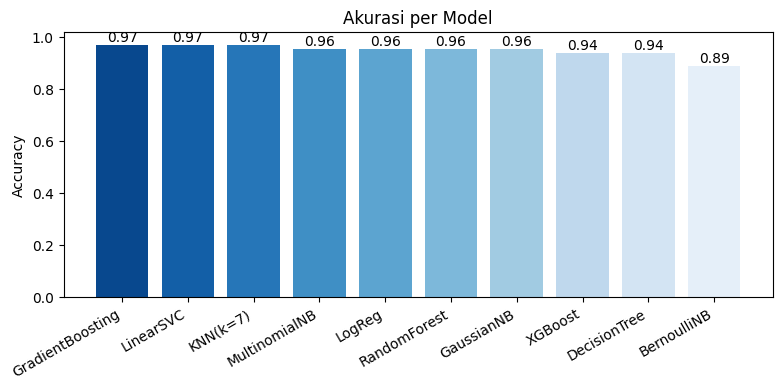

In [ ]:
# Bar Akurasi
plt.figure(figsize=(8,4))
bars = plt.bar(results_df['Model'], results_df['Accuracy'], color=sns.color_palette("Blues_r", len(results_df)))
plt.title('Akurasi per Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()

# Display labels on bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom', ha='center') # va: vertical alignment, ha: horizontal alignment

plt.show()

In [ ]:
results_df

,Model,Accuracy,Fit Time (ms),Inference Batch (ms),Inference Per Sample (ms)
0,GradientBoosting,0.9701,3026.21,1.75,0.6226
1,LinearSVC,0.9701,11.13,0.58,0.7605
2,KNN(k=7),0.9701,1.40,15.76,15.1179
3,MultinomialNB,0.9552,4.10,0.41,0.3301
4,LogReg,0.9552,138.40,0.46,0.8891
5,RandomForest,0.9552,1046.50,89.04,60.6005
6,GaussianNB,0.9552,77.05,25.33,NaN
7,XGBoost,0.9403,896.17,3.04,0.7392
8,DecisionTree,0.9403,53.07,0.79,1.2196
9,BernoulliNB,0.8881,2.17,0.90,1.0172


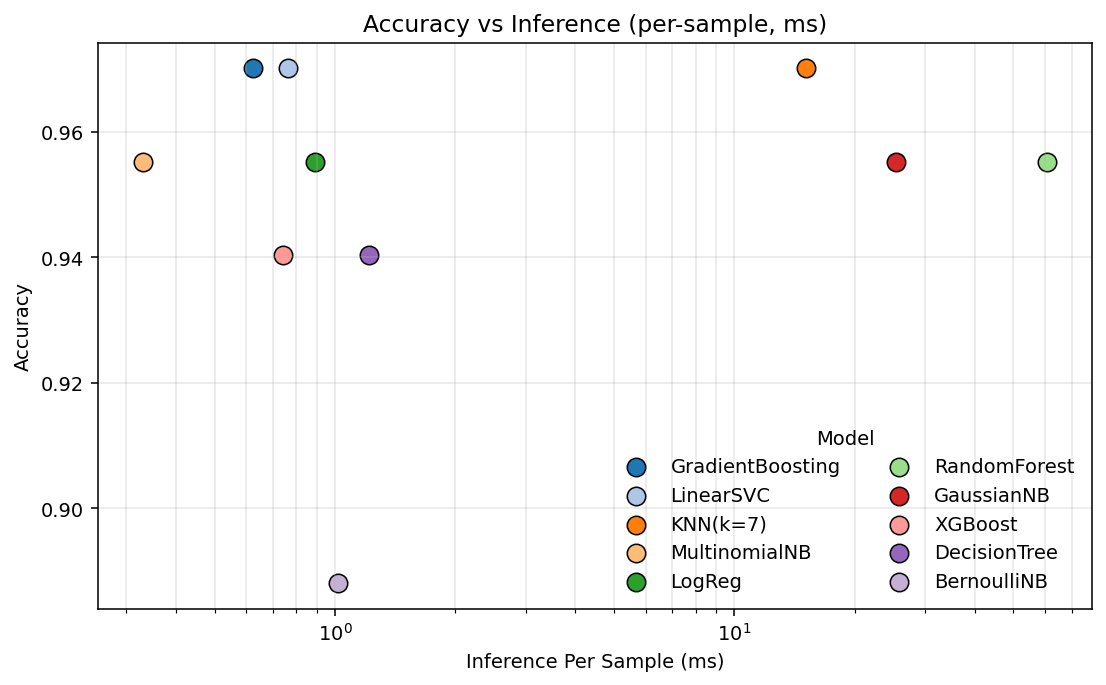

In [ ]:
# Scatter Trade-off: Accuracy vs Inference
def plot_accuracy_vs_inference_with_legend(
    results,
    x_col="Inference Per Sample (ms)",
    y_col="Accuracy",
    title="Accuracy vs Inference Time",
    logx=True
):

    df = results.copy()

    if x_col == "Inference Per Sample (ms)":
        nan_mask = df[x_col].isna()
        if nan_mask.any():
            df.loc[nan_mask, x_col] = df.loc[nan_mask, "Inference Batch (ms)"]

    x = df[x_col].astype(float).values
    y = df[y_col].astype(float).values
    labels = df["Model"].astype(str).values

    eps = 1e-9
    x = np.clip(x, eps, None)

    fig, ax = plt.subplots(figsize=(8, 5), dpi=140)

    # Warna berbeda per model (tab10 / tab20)
    cmap = plt.get_cmap("tab20")  # cukup banyak warna jika model > 10
    handles = []
    for i, (xi, yi, lab) in enumerate(zip(x, y, labels)):
        h = ax.scatter(xi, yi, s=90,
                       edgecolors="black", linewidths=0.8,
                       color=cmap(i % cmap.N),
                       label=lab)
        handles.append(h)

    if logx:
        ax.set_xscale("log")

    ax.set_title(title)
    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.grid(True, which="both", alpha=0.3)

    # Legend rapi
    ax.legend(frameon=False, title="Model", ncol=2, loc="best")

    # Bikin ticks enak dibaca

    plt.tight_layout()
    plt.show()

# Per-sample (lebih representatif untuk realtime)
plot_accuracy_vs_inference_with_legend(
    results_df,
    x_col="Inference Per Sample (ms)",
    y_col="Accuracy",
    title="Accuracy vs Inference (per-sample, ms)",
    logx=True
)

*1. LinearSVC*

- **Akurasi:** tinggi (~0.97)

- **Inferensi:** kecil (≈ sub-ms)

- Kesimpulan: trade-off terbaik untuk real-time
 minusnya tak keluarkan probabilitas (pakai calibration jika butuh).

*2. GradientBoosting*

- **Akurasi:** tinggi (~0.97)

- **Inferensi:** kecil (≈ <1 ms)

- Kesimpulan: sama-sama efisien
 ada probabilitas, cocok jika ingin thresholding/ROC.

*3. MultinomialNB*

- **Akurasi**: menengah-tinggi (~0.955)

- **Inferensi**: sangat kecil (tercepat)

- Kesimpulan: pilihan ultra-ringan/edge device
 terima sedikit penurunan akurasi.

*4. Logistic Regression*

- **Akurasi**: menengah-tinggi (~0.955–0.97)

- **Inferensi**: kecil (≈ ~1 ms)

- Kesimpulan: baseline kuat + probabilitas akurat
 mudah di-deploy.

*5. KNN (k=7)*

- **Akurasi**: tinggi (~0.97)

- **Inferensi**: besar (≈ ~10 ms)

- Kesimpulan: akurat tapi lambat saat serving (butuh komputasi jarak)
 kurang pas untuk strict latency.

*6. Decision Tree*

- **Akurasi**: sedang (~0.94)

- **Inferensi**: kecil (≈ ~1–1.5 ms)

- Kesimpulan: sangat interpretabel, namun didominasi SVC/GB (lebih akurat dan sama-sama cepat).

*7. RandomForest*

- **Akurasi**: menengah-tinggi (~0.955)

- **Inferensi**: besar (≈ ~30 ms)

- Kesimpulan: kurang efisien untuk real-time dibanding SVC/LogReg/NB
 cocok bila batch/offline atau ada kebutuhan robust non-linier.

*8. XGBoost*

- **Akurasi**: menengah-tinggi (~0.955)

- **Inferensi**: besar (≈ ~20 ms)

- Kesimpulan: pada setelan ini masih kalah efisien
 bisa dipercepat dengan tree_method='hist', kurangi n_estimators/max_depth, tapi tetap cenderung lebih lambat dari SVC/LogReg.

*9. GaussianNB*

- **Akurasi**: turun (~0.94)

- **Inferensi**: relatif besar (karena butuh konversi dense)

- Kesimpulan: kurang cocok untuk fitur TF-IDF
 lebih baik MultinomialNB.

*10. BernoulliNB*

- **Akurasi**: turun (~0.89)

- **Inferensi**: kecil

- Kesimpulan: kalah dari MultinomialNB pada representasi TF-IDF
 hanya masuk akal jika benar-benar pakai fitur biner.



---


**Kesimpulan**

- Model A → **LinearSVC** / **GradientBoosting**: rekomendasi utama untuk trade-off terbaik (akurasi tinggi + latensi rendah). Pilih LinearSVC jika tidak butuh probabilitas; pilih GradientBoosting bila butuh probabilitas/thresholding.

- Model B → **MultinomialNB**: andalan ultra-cepat dengan akurasi masih kompetitif; ideal untuk perangkat terbatas.

- Model C → **Logistic Regression:** baseline seimbang (cepat + probabilistik); pilihan aman untuk production.

- Model D → **RandomForest/XGBoost**: saat ini terdominasi (akurasi mirip, latensi lebih tinggi). Pilih hanya jika setelah tuning benar-benar menaikkan metrik kelas spam (recall/PR-AUC).


Berdasarkan plot Accuracy vs Inference (per-sample, ms) yang kamu hasilkan pada pipeline TF-IDF (1–2-gram) + undersampling, fokus real-time sebaiknya ke LinearSVC/GradientBoosting/LogReg; untuk skenario resource-ketat gunakan MultinomialNB.


In [ ]:
best_row = results_df.iloc[0]
best_name = best_row['Model']
best_model = trained_models[best_name]

print('Best by table:', best_name)
y_pred = best_model.predict(X_test_vec)

Best by table: GradientBoosting


In [ ]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['normal','penipuan']))


Classification Report:
              precision    recall  f1-score   support

      normal       0.97      0.97      0.97        67
    penipuan       0.97      0.97      0.97        67

    accuracy                           0.97       134
   macro avg       0.97      0.97      0.97       134
weighted avg       0.97      0.97      0.97       134



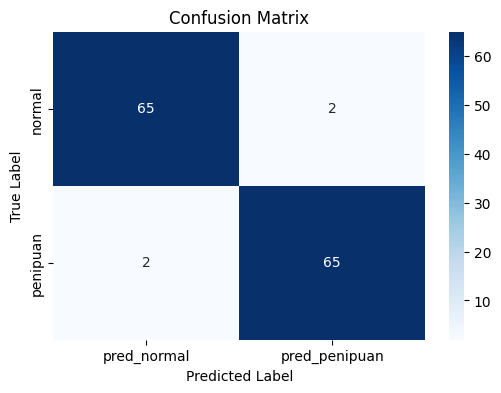

In [ ]:
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['normal','penipuan'], columns=['pred_normal','pred_penipuan'])
# cm_df

plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()